# Map-Reduce

## Review

We discussed the motivation and general layout of the Fantasy Football take-bot.

We built an outer graph that builds our experts with an interview sub-graph.

## Goals

Now, how can we run all interviews in parallel! 

We'll introduce [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/), which enables efficient task decomposition and parallel processing. 

It involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.

LangGraph has support for this using the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) API!

In [ ]:
%%capture --no-stderr
%pip install --quiet -U sqlite3 langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

## Gather expert sources

As before, we'll get our sources.

In [1]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_reddit_post(url):
    ''' Get reddit post comments '''

    # Fetch the submission
    submission = reddit.submission(url=url)
    
    # Load the comments
    submission.comments.replace_more(limit=None)
    comments = submission.comments.list()
    
    # Concatenate comments into a single string
    reddit_context = "\n *** user commnent *** \n".join([comment.body for comment in comments])
    return reddit_context

# Context for experts 
draft_strategy_context = get_reddit_post("https://www.reddit.com/r/fantasyfootball/comments/1ewk6kr/theres_only_one_draft_strategy_that_ill_ever/")
top_player_context = get_reddit_post("https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/")

## Build graph

### State

In [28]:
import operator

from typing_extensions import TypedDict, List, Annotated

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from langgraph.graph import MessagesState

class Expert(BaseModel):
    name: str = Field(
        description="Name of the expert.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the expert.",
    )
    context: SystemMessage = Field(
        description="Instructions used by the expert.",
    )

    def answer(self, dicussion: List) -> AIMessage:
        return llm.invoke([self.context]+dicussion)

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take or perspective",
    )
    take: str = Field(
        description="Fun, punchy observation from the discussion between expert and interviewer.",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class OverallState(TypedDict):
    topic: str
    experts: List[Expert]
    takes: Annotated[List[Take], operator.add]

class InterviewState(MessagesState):
    topic: str
    expert: Expert
    
class InterviewOutputState(TypedDict):
     takes: List[Take]

### Parameters and LLM

In [29]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

max_num_turns = 4

### Graph

In [34]:
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

from langchain_core.runnables import chain as as_runnable

@as_runnable
def generate_experts(state: OverallState):
    """ Generate our experts """
    
    preamble = "You are an expert in in Fantasy Football. You are being interviewed by an analyst. Don't make up your own answers."
    
    draft_strategy_expert = Expert(
        name="Moe",
        role="Fantasy Draft Strategy Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {draft_strategy_context}"),
    )
    
    top_player_expert = Expert(
        name="Jimbo",
        role="Top Players To Draft Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {top_player_context}"),
    )

    return {"experts": [draft_strategy_expert, top_player_expert]}

@as_runnable
def generate_question(state: InterviewState):
    """Node to generate a question """

    instructions = SystemMessage(content=f"""
    
    You are an analyst tasked with interviewing an expert to learn about a specific topic. 
    
    Here is your topic: {state["topic"]}
    
    1. Interesting: Insights that people will find surprising or non-obvious.
    
    2. Specific: Insights that avoid generalities and include specific examples from the expert.
    
    Begin by introducing yourself, and then ask your question.
    
    Continue to ask questions to drill down and refine your understanding of the topic.
    
    As the interview proceeds for a bit, assess your understanding.
    
    If you are satisfied, then complete the interview with: "Thank you so much for your help!"
    
    Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""")
    
    # Generate question 
    result = llm.invoke([instructions]+state["messages"])   
    
    # Write messages to state
    return {"messages": [HumanMessage(content=result.content,name='Interviewer')]}

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    messages = state["messages"]
    expert = state["expert"]
   
    # Answer question
    answer = expert.answer(messages)
    
    # Use this to track expert responses
    answer.name = 'expert'
    
    # Append it to state
    return {"messages": [answer]}

@as_runnable
def generate_takes(state: InterviewState):
    """ Node to answer a question """

    # Get discussion
    messages = state["messages"]

    # Instructions
    instructions = SystemMessage(content=f"""Distill the conversation between the analyst and expert into a set of fun, punchy takes. Use specific players / examples in your takes to liven then up and keep them specific.""")

    # Structured output
    structured_llm = llm.with_structured_output(Takes)
    
    # Answer question
    takes = structured_llm.invoke([instructions]+messages)
        
    # Append it to state
    return {"takes": [takes]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "generate_takes"

    # This router is run after each question - answer pair 
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "generate_takes"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(input=InterviewState, output=InterviewOutputState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("generate_takes", generate_takes)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','generate_takes'])
interview_builder.add_edge("generate_takes", END)

### Map-reduce

Now, see that we use the `Send` API to spawn an interview for each expert in our list of experts!

Note that the final node in each interview updates state as shown here:

```
return {"takes": [takes]}
```

And note that the overall state has a `takes` key with reducer that can append! 

```
takes: Annotated[List[Take], operator.add]
```

So, we will perform all interviews in parallel and append each list to the `takes` key in our `OverallState`!

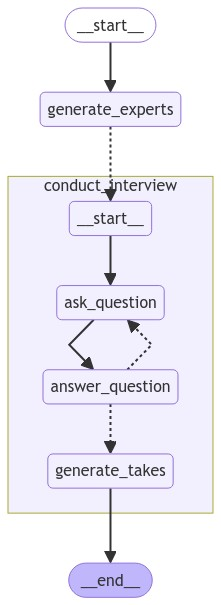

In [50]:
import sqlite3

from langgraph.constants import Send
from langgraph.checkpoint.sqlite import SqliteSaver

def initiate_all_interviews(state: OverallState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    topic = state["topic"]
    return [Send("conduct_interview", {"topic": topic,
                                       "expert": expert}) for expert in state["experts"]]

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("generate_experts", generate_experts)
overall_builder.add_node("conduct_interview", interview_builder.compile())

overall_builder.add_edge(START, "generate_experts")
overall_builder.add_conditional_edges("generate_experts", initiate_all_interviews, ["conduct_interview"])
overall_builder.add_edge("conduct_interview", END)

# Memory
db_path = "state_db/final_assistant.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

# Compile
graph = overall_builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [51]:
thread = {"configurable": {"thread_id": "1"}}

topic = "An overall thesis for top players to draft and draft strategy for Fantasy Football."

result = graph.invoke({"topic": topic}, thread)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


In [52]:
from IPython.display import Markdown, display
for t in result['takes']:
    for take in t.takes:
        display(Markdown(f"### {take.title}\n{take.take}\n"))

### Cooper Kupp's 2021 Gamble
Drafting Cooper Kupp in the third round of 2021, despite his ADP suggesting a later pick, paid off massively. Kupp led the league in receptions, receiving yards, and touchdowns, propelling one manager to a championship.


### Mahomes Magic in 2018
In 2018, one savvy manager drafted Patrick Mahomes in the 7th round, well ahead of his ADP. Mahomes threw for over 5,000 yards and 50 touchdowns, becoming the top fantasy QB and leading that manager to victory.


### Trust Your Gut, Win Big
Whether it's Cooper Kupp or Patrick Mahomes, trusting your research and instincts over ADP can turn a risky pick into a league-winning move.


### Deebo Samuel: The Steal of the Draft
Deebo Samuel is a fifth-round gem at WR20 in ESPN leagues. Despite Brandon Aiyuk's presence, Samuel's talent and role make him a steal.


### Avoid the Olave Trap
Chris Olave's ADP is WR9, but he finished as WR19 last season. Without significant changes in his situation, he's overvalued.


### Kenneth Walker: Undervalued Workhorse
Kenneth Walker is a prime example of a valuable pick. With an established role and a favorable coaching staff, he's a steal compared to other RBs with question marks.


### Jake Ferguson: Late-Round Gold
Tight end is deep this year, so wait and snag Jake Ferguson. As TE10 on ESPN, he's set to be the #2 target in Dallas, offering great late-round value.


### Selective Handcuffing: The Smart Play
Handcuffing can be valuable, but be selective. If you draft a high-risk player like Jonathan Brooks, handcuff him with Chuba Hubbard to protect against injury or underperformance.


### Flexibility is Key
One common mistake is overcommitting to a rigid draft strategy. Stay flexible and adapt to the draft's flow to capitalize on value.


### Value Over Name Recognition
Avoid reaching for players based on name recognition or past performance. Focus on current situations and value to avoid overpaying.
